The plan for this notebook is to alter how the tasks dictionary is generated. 

Firstly, this should be changed such that when a dictionary is generated is actually has the correct number of tasks. That means that the check digits should be unique for some number of checks.

Further, I should have the ability to introduce correlation into the tasks. Some check digits should be made manually common between tasks. Ideally these should grok together.

First, I think I will run this using a manually created tasks dictionary.

In [2]:
# Library import cell

import numpy as np
#import secrets
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import itertools
from scipy.optimize import curve_fit
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Function cell

def generate_random_binary_string(length):
    binary_string = ''.join(np.random.choice(['0', '1'], size=length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}
    
    if n_tasks > np.power(2, len_taskcode):
        print("Error: n_tasks is too large")
        return False

    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)

        if binary_string not in unique_strings:
            unique_strings.add(binary_string)

            integer_list = np.random.choice(range(len_message), size=num_checks, replace=False).tolist()
            tasks_dict[binary_string] = integer_list

    return tasks_dict


def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict))
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

def generate_dataset_for_task(task_code, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = task_code
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

# IS NOT USING BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y

In [6]:
# Parameters
n_tasks = 4 # number of tasks created
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 8  # Maximum integer value in the associated integer list
#num_samples_list = np.logspace(start=3, stop=5, num=10, base=10, dtype=int) # number of samples created in the dataset
num_samples_list = [5000]
samples_per_task = 2000
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32
num_epochs = 8000
test_frac = 0.2
num_layers = 4
hidden_size = 64

for num_samples in num_samples_list:
    # Train the model
    tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message) # Moved intentionally earlier
    #tasks_dict = {'10010000': [4,2,5], '10010000': [4,2,5], '10010000': [4,2,5], '01001011': [1,3,7]}
    print("tasks_dict = ", tasks_dict.items())
    [data, value] = generate_dataset(tasks_dict, num_samples)

    # Create a dataframe for training
    df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

    # Split the data into training and test sets
    train_df, test_df = train_test_split(df, test_size=test_frac)

    # Create instances of the neural network
    model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

    # Define loss function and optimizer (same as before)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Create DataLoaders for the training and test data
    train_dataset = CustomDataset(train_df)
    test_dataset = CustomDataset(test_df)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_loss_list = np.empty(num_epochs)
    test_loss_list = np.empty(num_epochs)

    train_accuracy_list = np.empty(num_epochs)
    test_accuracy_list = np.empty(num_epochs)

    accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

    print(f'{num_samples} samples')

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()

        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels.unsqueeze(1))

            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()

            # Compute accuracy
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Calculate average train loss
        train_loss = train_loss / len(train_dataset)
        # Calculate average train accuracy
        train_accuracy = train_correct / train_total

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                test_correct += (predictions == labels).sum().item()
                test_total += labels.size(0)

                loss = criterion(outputs, labels.unsqueeze(1))
                test_loss += loss.item() * inputs.size(0)

            # Calculate average test loss
            test_loss = test_loss / len(test_dataset)

        # Calculate average test accuracy
        test_accuracy = test_correct / test_total

        # Update the loss lists
        train_loss_list[epoch] = train_loss
        test_loss_list[epoch] = test_loss

        train_accuracy_list[epoch] = train_accuracy
        test_accuracy_list[epoch] = test_accuracy

        # Find accuracy data
        tasks_list = list(tasks_dict.keys())
        for i in range(n_tasks):
          task_code = tasks_list[i]
          #print(f"task_code = ", task_code)
          [data_per_task, value_per_task] = generate_dataset_for_task(task_code, samples_per_task)
          #print(data_per_task)
          df_per_task = pd.DataFrame(np.concatenate((data_per_task, value_per_task.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
          #print(df_per_task)
          dataset_per_task = CustomDataset(df_per_task)
          loader_per_task = DataLoader(dataset_per_task, batch_size=batch_size, shuffle=True)
          model.eval()
          task_correct = 0
          task_total = 0
          with torch.no_grad():
            for inputs, labels in loader_per_task:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                task_correct += (predictions == labels).sum().item()
                task_total += labels.size(0)
                #print(f'inputs = ', inputs)
                #print(f'labels.size(0) = ', labels.size(0))

                #loss = criterion(outputs, labels.unsqueeze(1)) #if in future I want to calculate loss
                #test_loss += loss.item() * inputs.size(0)
            task_accuracy = task_correct / task_total
            #print(f"task_accuracy = ", task_accuracy)
            accuracy_array[(i, epoch)] = task_accuracy
        #print(f"accuracy_array = {accuracy_array} at epoch {epoch}")
        # Print epoch information
        #print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")


    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the training and test losses on the first subplot
    axs[0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
    axs[0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot the training and test accuracies on the second subplot
    axs[1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
    axs[1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Adjust the spacing between subplots
    #plt.tight_layout()
    plt.suptitle(f'Model performance for {num_samples} data points')
    # Show the subplots
    plt.show()
    
# Display model parameter number. If model is changed, should go into the loop
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters = {pytorch_total_params}")

tasks_dict =  dict_items([('10010000', [4, 2, 5]), ('01001011', [1, 3, 7])])
5000 samples


  0%|          | 0/8000 [00:01<?, ?it/s]


IndexError: list index out of range

In [ ]:
accuracy_array_copy = accuracy_array

In [5]:
# Define the colourmap
color_map = plt.cm.get_cmap('viridis_r', n_tasks)

# Plotting each array with its corresponding index as the label and color
for i in range(n_tasks):
    plt.plot(np.arange(0, num_epochs, 1), accuracy_array[i], label='Task ' + str(i+1), color=color_map(i))

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
#plt.legend()

# Create a colorbar indicating the task numbers
sm = plt.cm.ScalarMappable(cmap=color_map)
sm.set_array(range(1, n_tasks + 1))
plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, 1), label='Task Number')

# Show the plot
plt.show()

NameError: name 'accuracy_array' is not defined

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\AppData\Local\Temp\ipykernel_5016\6332751.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 1, 6, dtype=int), label='Task Number')


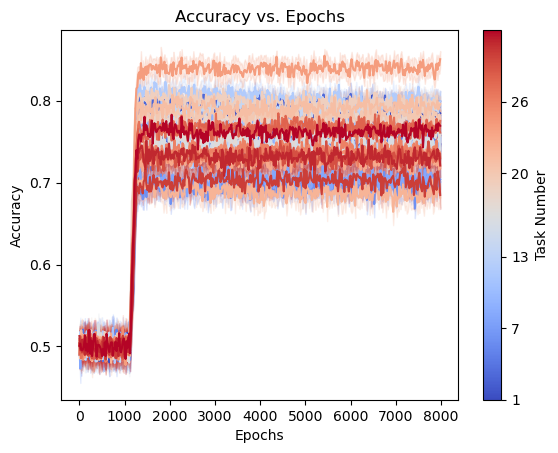

In [125]:
# Define the moving average window
moving_avg = 20

# Calculate the filtered epochs
epochs = np.arange(0, num_epochs, moving_avg)
filtered_epochs = epochs[:len(epochs)//moving_avg * moving_avg]

# Create an empty DataFrame
df = pd.DataFrame()

# Loop over the tasks and reshape the accuracy array
for i in range(n_tasks):
    reshaped_accuracy_array = np.reshape(accuracy_array[i], (-1, moving_avg))
    
    # Create a temporary DataFrame for the current task
    temp_df = pd.DataFrame({
        'Epochs': np.repeat(filtered_epochs, moving_avg),
        'Accuracy': np.ndarray.flatten(reshaped_accuracy_array),
        'Task': i + 1
    })
    
    # Concatenate the temporary DataFrame to the main DataFrame
    df = pd.concat([df, temp_df])
    
# Create a colourbar plot for different tasks, in seaborn. Useful for smoothing stuff out a bit.
# It was getting a bit hard to read with the very high variability.

# Define the color map
color_map = 'coolwarm'  # Change the color map here

# Plotting the data using seaborn
sns.lineplot(data=df, x='Epochs', y='Accuracy', errorbar=('ci', 95), estimator='mean', hue='Task', palette=color_map)

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

sm = plt.cm.ScalarMappable(cmap=color_map)
sm.set_array(range(1, n_tasks + 1))
#plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, int(n_tasks+1)/10), label='Task Number')
plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 1, 6, dtype=int), label='Task Number')

# Remove the legend inside the plot
plt.legend().remove()

# Show the plot
plt.show()

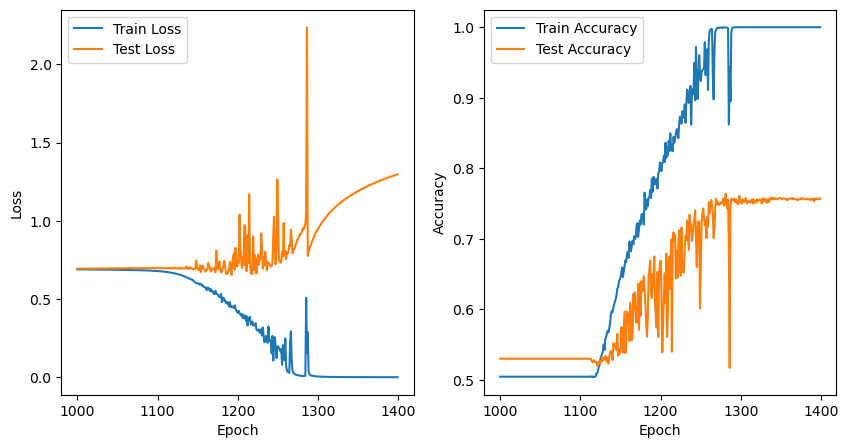

In [132]:
# For plotting part of the loss and accuracy change over epoch number. Useful for highlighting changes.

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

start = 1000
end = 1400
x = range(start, end)
new_train_loss_list = train_loss_list[start:end]
new_test_loss_list = test_loss_list[start:end]
new_train_accuracy_list = train_accuracy_list[start:end]
new_test_accuracy_list = test_accuracy_list[start:end]

# Plot the training and test losses on the first subplot
axs[0].plot(x, new_train_loss_list, label='Train Loss')
axs[0].plot(x, new_test_loss_list, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and test accuracies on the second subplot
axs[1].plot(x, new_train_accuracy_list, label='Train Accuracy')
axs[1].plot(x, new_test_accuracy_list, label='Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\AppData\Local\Temp\ipykernel_5016\3618364231.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, 1), label='Task Number')


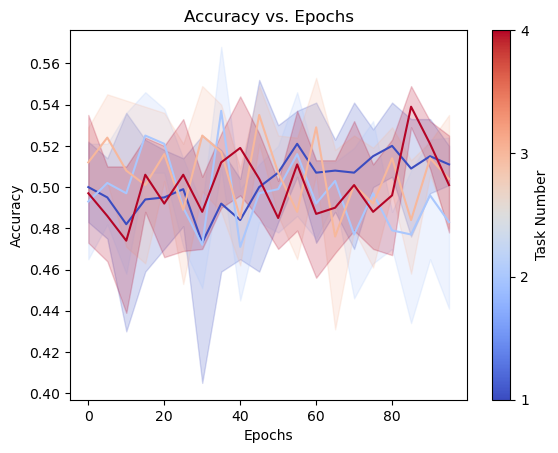

In [83]:
# Create a colourbar plot for different tasks, in seaborn. Useful for smoothing stuff out a bit.
# It was getting a bit hard to read with the very high variability.

# Define the color map
color_map = 'coolwarm'  # Change the color map here

# Plotting the data using seaborn
sns.lineplot(data=df, x='Epochs', y='Accuracy', errorbar=('ci', 95), estimator='mean', hue='Task', palette=color_map)

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

sm = plt.cm.ScalarMappable(cmap=color_map)
sm.set_array(range(1, n_tasks + 1))
plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, 1), label='Task Number')

# Remove the legend inside the plot
plt.legend().remove()

# Show the plot
plt.show()

In [127]:
num_layers = 8
hidden_size = 256
model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

398593
